In [9]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
from data import SimpleDataset, CellImageDataset
import seaborn as sns
import pandas as pd
from sklearn import mixture
import numpy as np
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.special import softmax
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from microfilm.colorify import multichannel_to_rgb
from sklearn.cluster import AgglomerativeClustering
import multiscale_phate
import scprep

In [10]:
imsize = 512
batch_size = 100
DATA_DIR = Path("/data/ishang/FUCCI-data/")
NAME = "default_unscaled_512_crop_008_sharp"
EMBEDDINGS_DATASET = DATA_DIR / f"embeddings_{NAME}.pt"
EMBEDDINGS_DATASET = EMBEDDINGS_DATASET.parent / ("ref_" + EMBEDDINGS_DATASET.name)

In [11]:
dataset = CellImageDataset(DATA_DIR / f"index_{NAME}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"])

Loading dataset images:   0%|          | 0/5 [00:00<?, ?it/s]

Loading dataset images: 100%|██████████| 5/5 [02:46<00:00, 33.34s/it]


Loaded 45993 images from 2346 files.


In [12]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [13]:
embeddings = torch.load(EMBEDDINGS_DATASET)

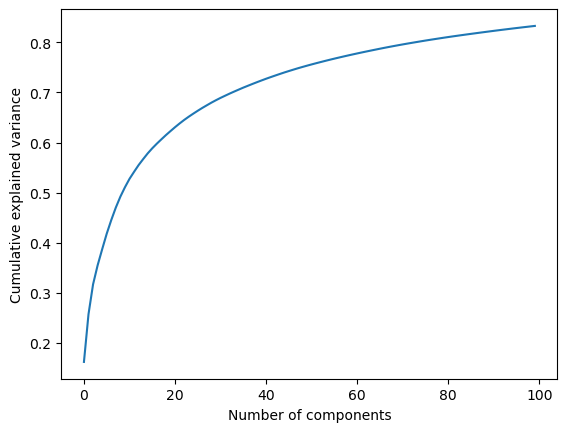

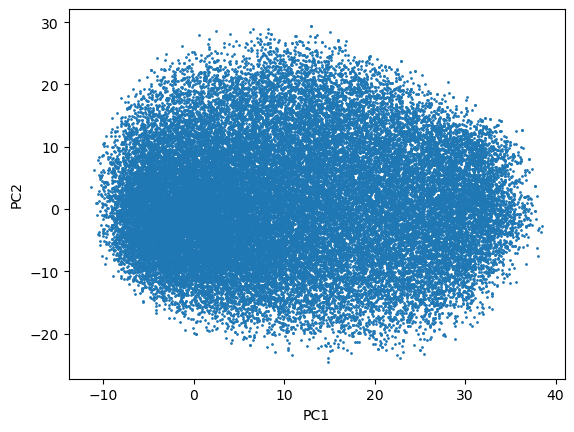

PC explained variance, first 10 components:
[0.161909   0.09526959 0.05957718 0.03797845 0.0320868  0.03111741
 0.02725883 0.02498675 0.02175714 0.01869027]


In [14]:
scaler = StandardScaler()
pca = PCA(n_components=100)
scaler.fit(embeddings)
pca.fit(embeddings)
embeddings_pca = pca.transform(scaler.transform(embeddings))

# plot cdf of variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

# plot 2d pca
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], s=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("PC explained variance, first 10 components:")
print(pca.explained_variance_ratio_[:10])

In [15]:
embeddings_2d = torch.tensor(embeddings_pca[:, :2])

In [16]:
x_ax_range = np.linspace(embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max(), 20)
y_ax_range = np.linspace(embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max(), 20)
nrow = len(x_ax_range)
images = []
blanks = 0
tolerance = ((0.5 * (x_ax_range[1] - x_ax_range[0])) ** 2 + (0.5 * (y_ax_range[1] - y_ax_range[0])) ** 2)
for lattice_col in x_ax_range:
    for lattice_row in y_ax_range:
        # find the image closest to this point in the intensity space
        point = torch.tensor([lattice_col, lattice_row])
        distances = torch.sum((embeddings_2d - point) ** 2, dim=1)
        closest = torch.argmin(distances)

        # if the closest image is too far away, just add a blank image
        if distances[closest] > tolerance:
            images.append(torch.zeros_like(dataset[closest]))
            blanks += 1
        else:
            images.append(dataset[closest])

print("total images", len(images))
print("number of blanks", blanks)
print("shape of image array", images[0].shape)

grid = make_grid(images, nrow=nrow)
print(grid.shape)

total images 400
number of blanks 86
shape of image array torch.Size([4, 512, 512])
torch.Size([4, 10282, 10282])


In [17]:
xlabels = np.round(x_ax_range[::2], 1)
xticks = (x_ax_range[::2] - np.min(x_ax_range)) / (np.max(x_ax_range) - np.min(x_ax_range)) * grid.shape[1]
print(xticks)
print(xlabels)
ylabels = np.round(y_ax_range[::2], 1)
yticks = (y_ax_range[::-2] - np.min(y_ax_range)) / (np.max(y_ax_range) - np.min(y_ax_range)) * grid.shape[2]
print(yticks)
print(ylabels)

[   0.         1082.31578947 2164.63157895 3246.94736842 4329.26315789
 5411.57894737 6493.89473684 7576.21052632 8658.52631579 9740.84210526]
[-11.3  -6.1  -0.8   4.4   9.7  14.9  20.1  25.4  30.6  35.9]
[10282.          9199.68421053  8117.36842105  7035.05263158
  5952.73684211  4870.42105263  3788.10526316  2705.78947368
  1623.47368421   541.15789474]
[-24.6 -18.9 -13.2  -7.5  -1.8   3.8   9.5  15.2  20.9  26.6]


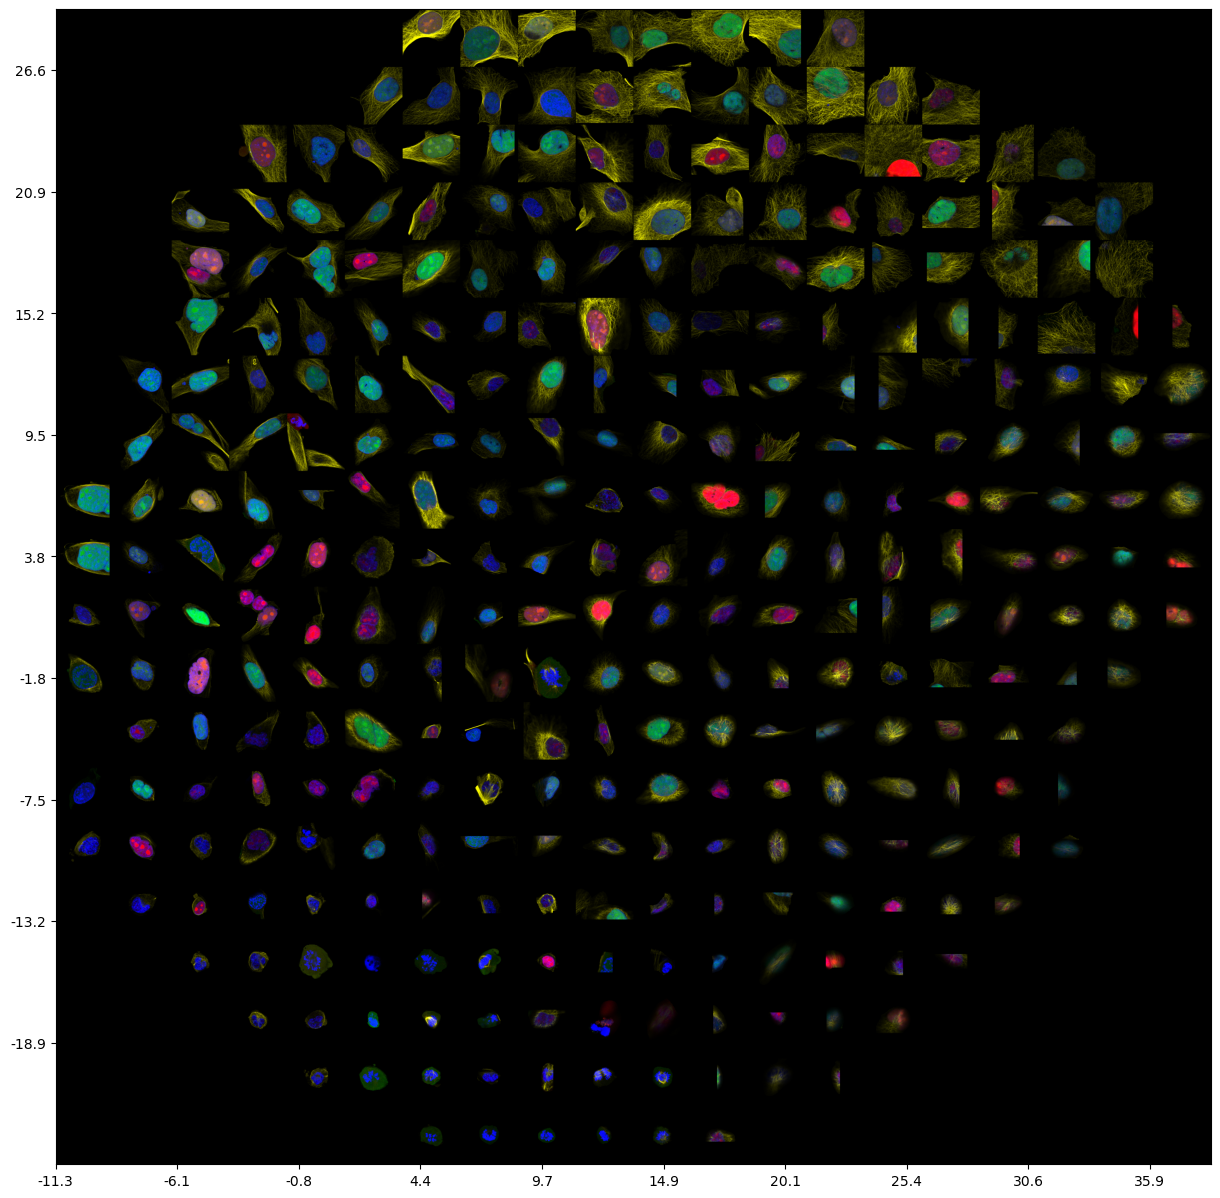

In [18]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid.cpu().numpy(), cmaps=cmaps)

plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

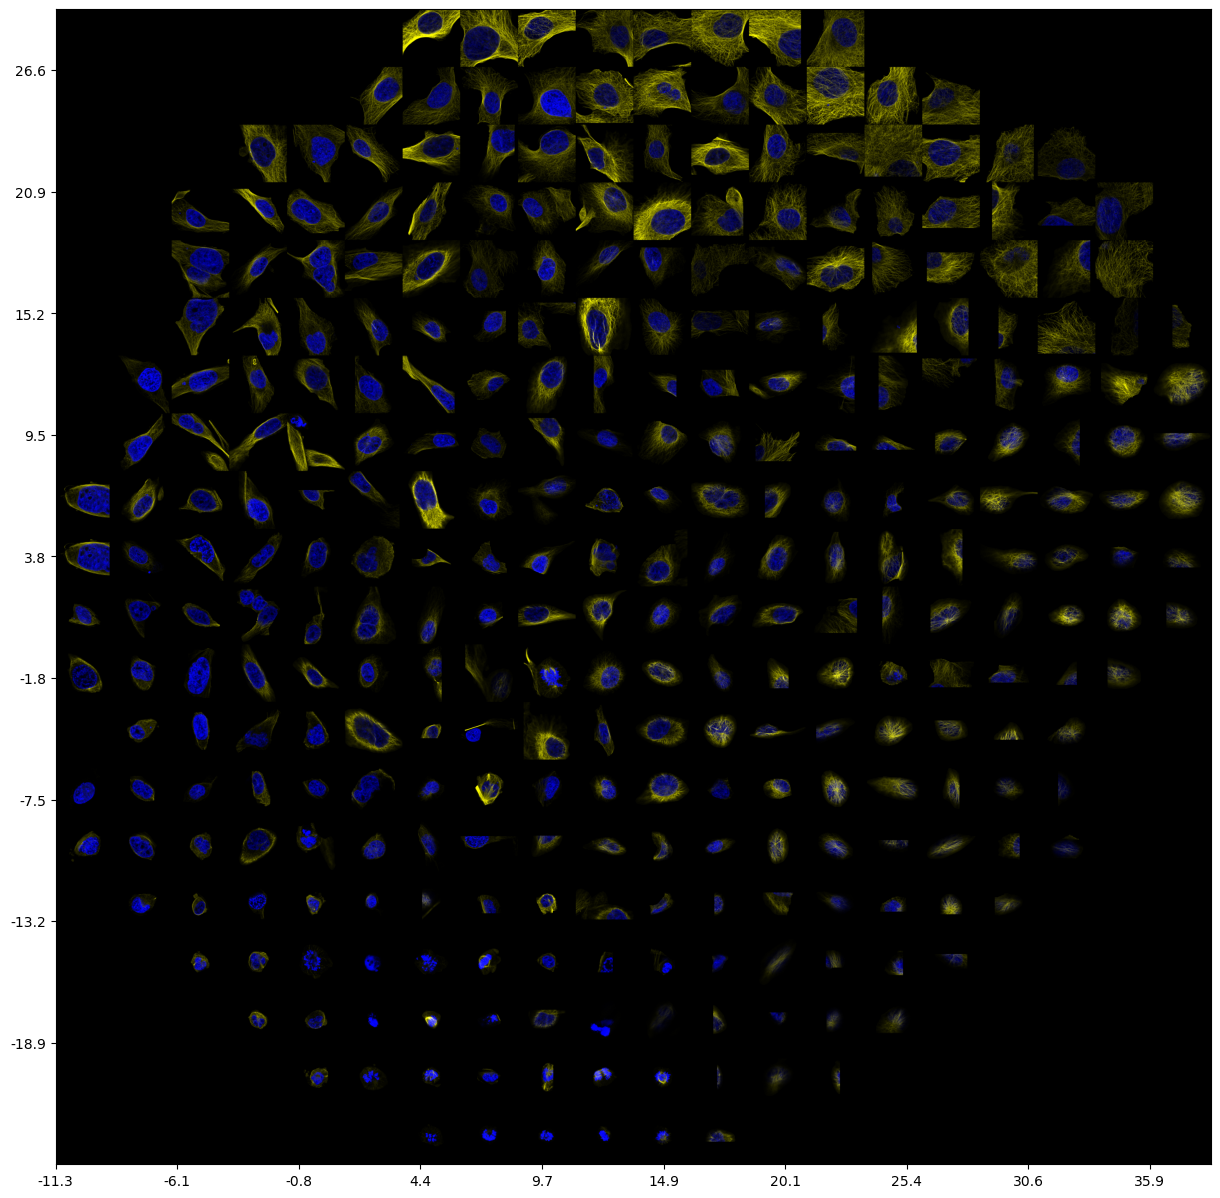

In [19]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[:2].cpu().numpy(), cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

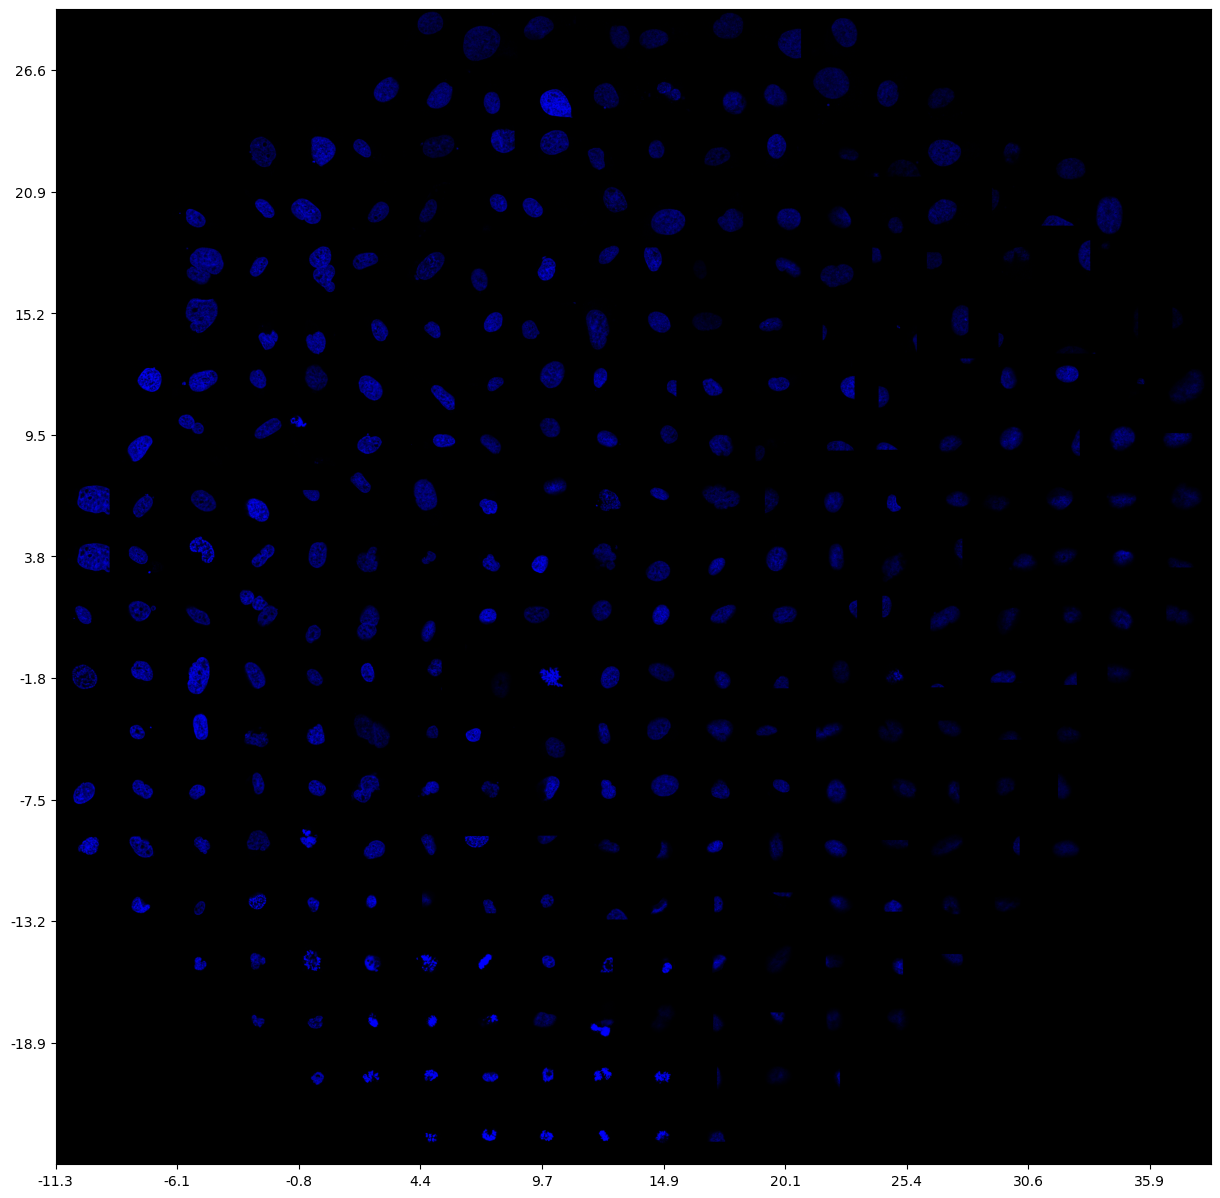

In [20]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[0:1].cpu().numpy(), cmaps=cmaps[0:1])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

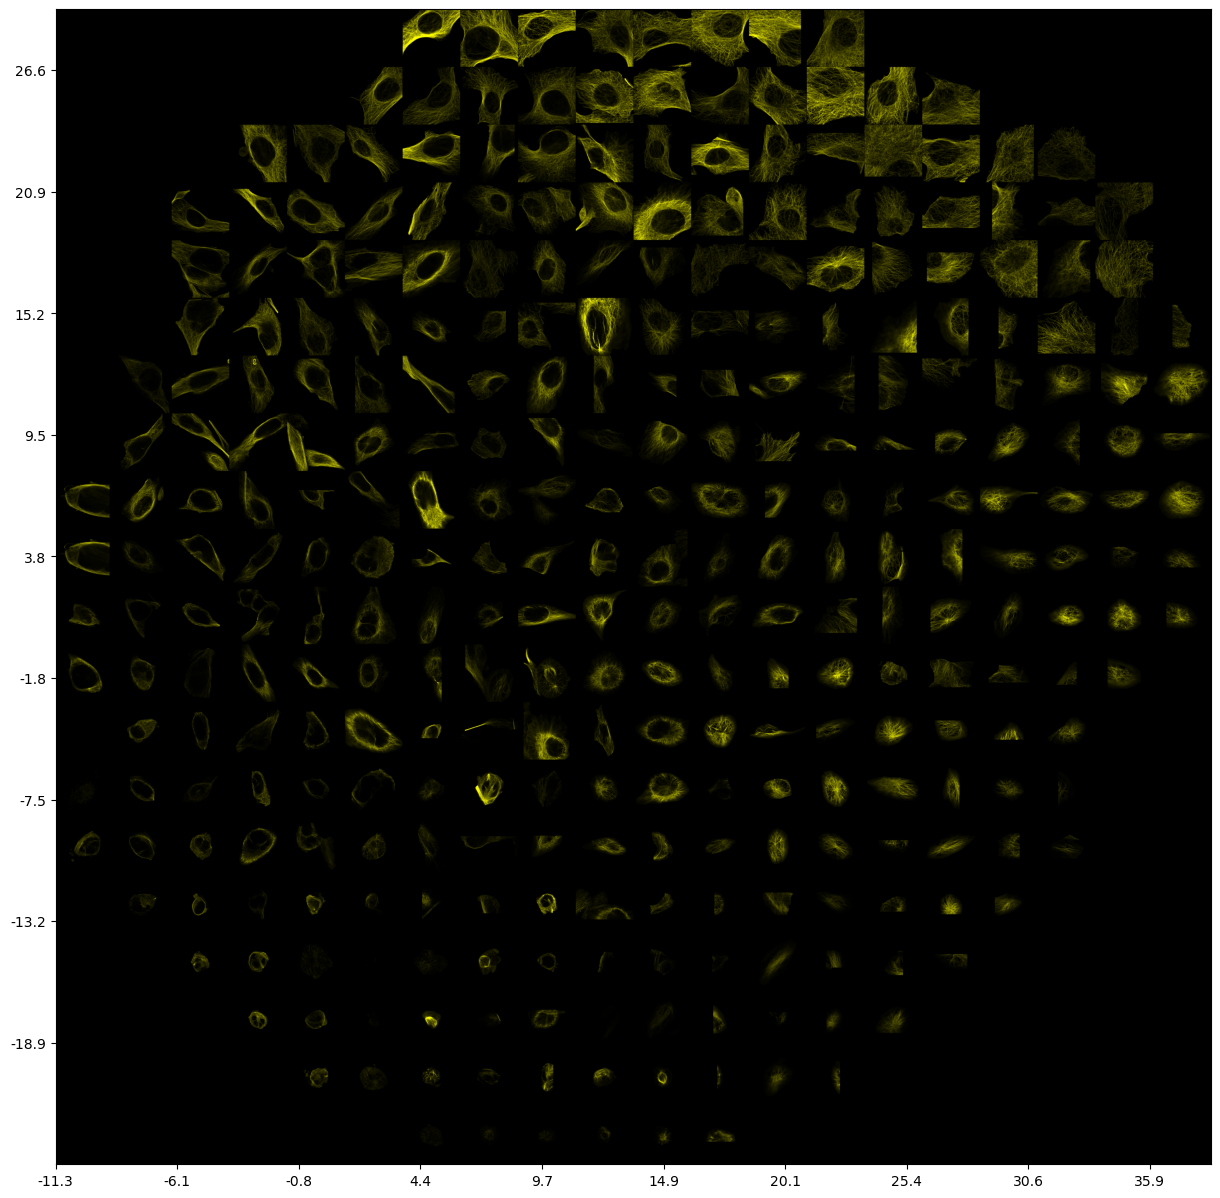

In [21]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[1:2].cpu().numpy(), cmaps=cmaps[1:2])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

In [22]:
embeddings_max = embeddings.max(dim=0)[0]
embeddings_min = embeddings.min(dim=0)[0]
embeddings_rescaled = (embeddings - embeddings_min) / (embeddings_max - embeddings_min)

nmf = NMF(n_components=10)
nmf.fit(embeddings_rescaled)
embeddings_nmf = nmf.transform(embeddings_rescaled)
# nmf.fit(embeddings_rescaled[:2000])
# embeddings_nmf = nmf.transform(embeddings_rescaled[:2000])

# plot cdf of error as number of components increase
# import time 

# err = []
# elapsed = []
# comp_range = [2 ** i for i in range(1, 5)]
# for comp in comp_range:
#     nmf_comp = NMF(n_components=comp)
#     start = time.time()
#     nmf_comp.fit(embeddings_rescaled[:1000])
#     elapsed.append(time.time() - start)
#     embeddings_nmf_comp = nmf_comp.transform(embeddings_rescaled[:1000])
#     err.append(nmf_comp.reconstruction_err_)

# fig, ax1 = plt.subplots(figsize=(8, 8))
# ax2 = ax1.twinx()
# ax1.plot(comp_range, err)
# ax2.plot(comp_range, elapsed, color="red")
# ax1.set_xlabel("Number of components")
# ax1.set_ylabel("Reconstruction error", color="blue")
# ax2.set_ylabel("Time (s)", color="red")
# plt.show()

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


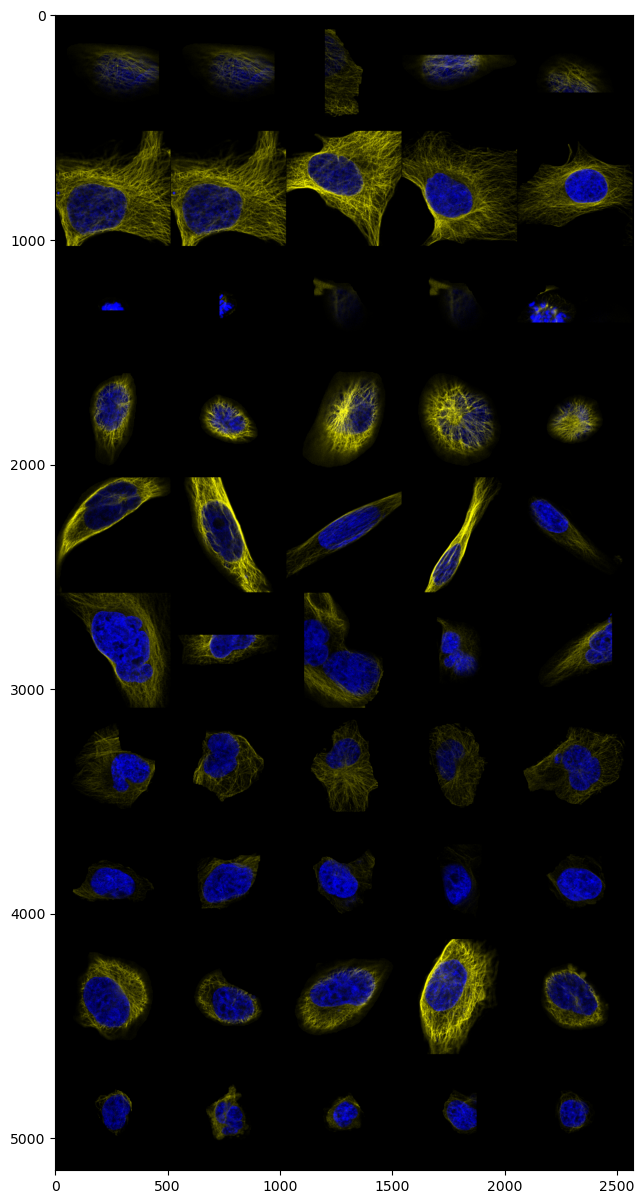

In [23]:
# display the images of the images that are closest to each NMF component
nrow = 5
images = []
for h in nmf.components_:
    distances = torch.sum((embeddings_rescaled - h) ** 2, dim=1)
    closest = torch.argsort(distances)[:nrow]
    images.extend([dataset[closest[i]] for i in range(nrow)])
grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid.cpu().numpy()[:2], cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.imshow(grid_rgb)


In [24]:
# load fucci channel intensities

intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")

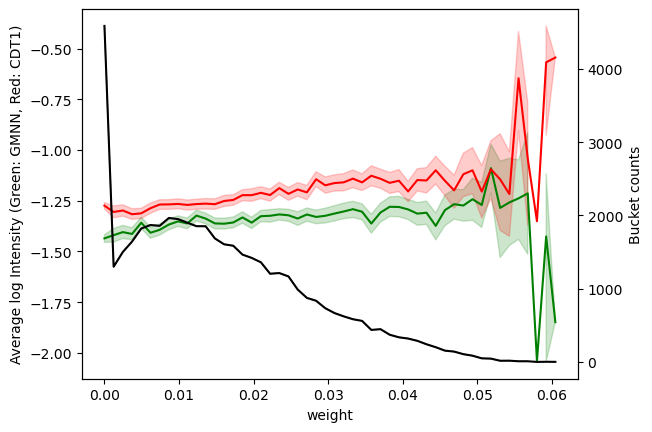

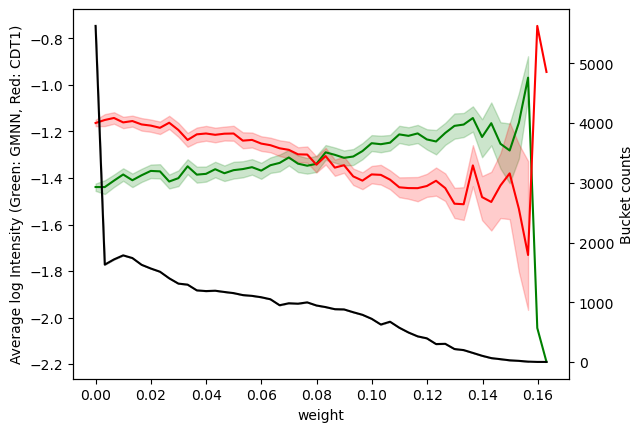

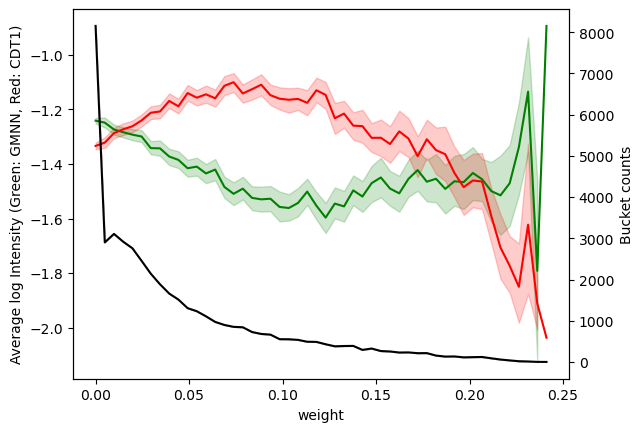

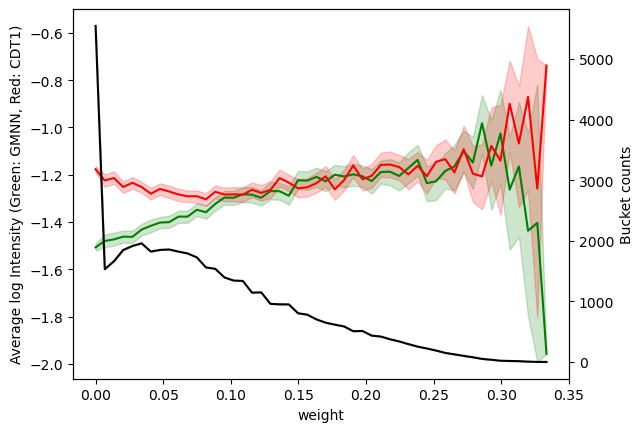

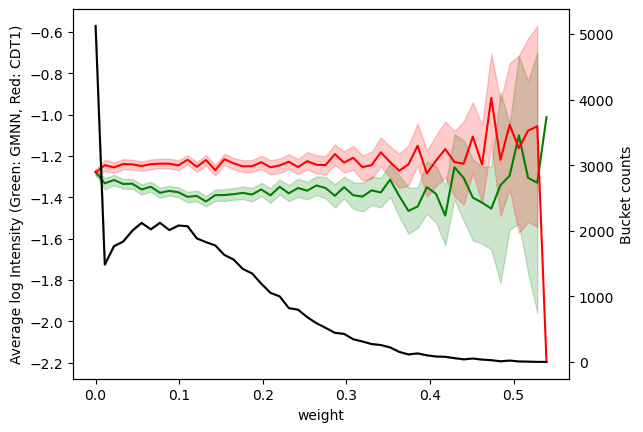

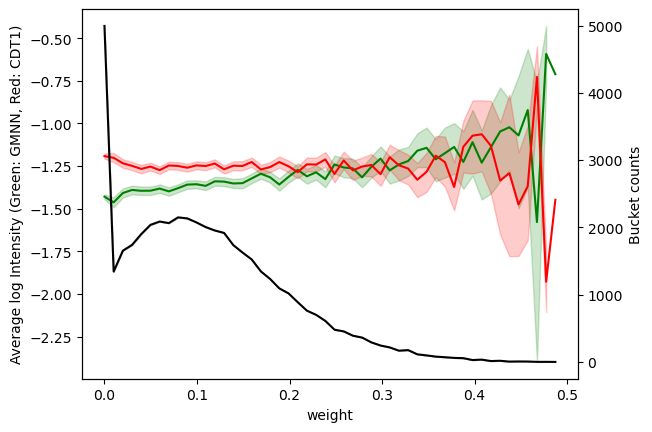

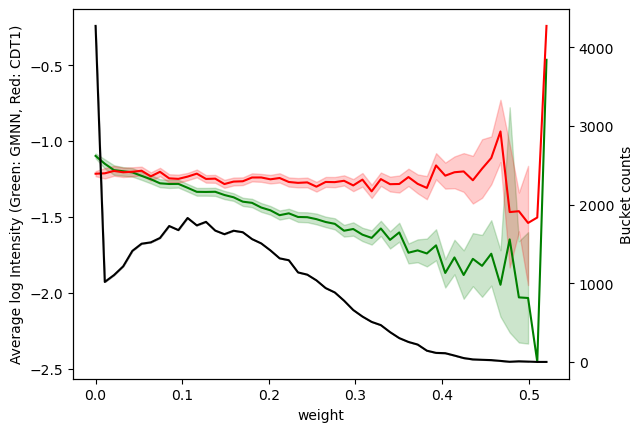

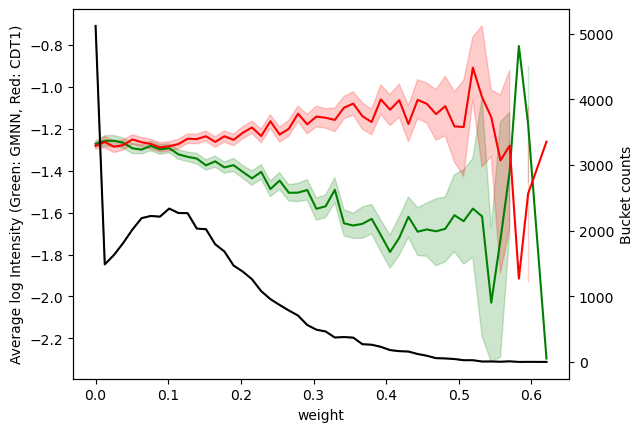

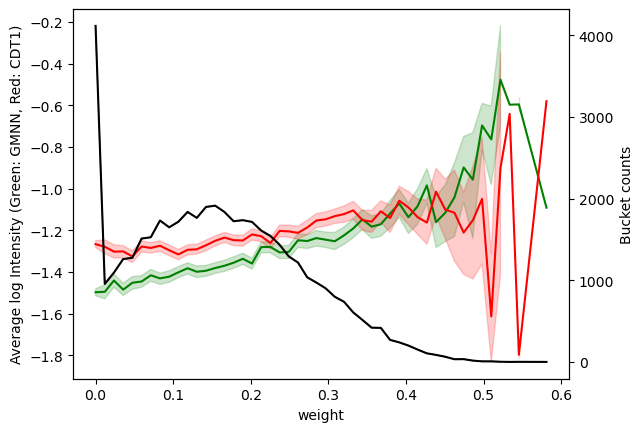

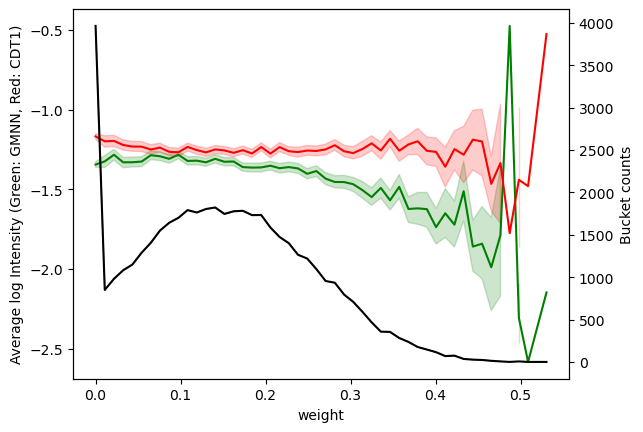

In [29]:
# plot GMNN intensity (green) and CDT1 intensity (red) by NMF component weight
# use sns and add NMF component weight and intensity as columns to a dataframe

for i in range(10):
    plt.clf()
    weight_buckets = np.linspace(embeddings_nmf[:, i].min(), embeddings_nmf[:, i].max(), 50)
    bucketed_weights = weight_buckets[np.digitize(embeddings_nmf[:, i], weight_buckets) - 1]
    df = pd.DataFrame({"weight": bucketed_weights, "GMNN": intensities[:, 0], "CDT1": intensities[:, 1]})
    sns.lineplot(data=df, x="weight", y="GMNN", color="green")
    sns.lineplot(data=df, x="weight", y="CDT1", color="red")
    plt.ylabel("Average log Intensity (Green: GMNN, Red: CDT1)")
    # plot the counts of each weight bucket
    plt.twinx()
    sns.lineplot(data=df, x="weight", y="weight", estimator=lambda x: len(x), color="black")
    plt.ylabel("Bucket counts")
    plt.show()